### Imports

In [1]:
import msd_pytorch as mp
from torch.utils.data import DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt

### Generate data

In [ ]:
import timeit
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tomophantom
from tomophantom import TomoP3D
from tomophantom.supp.qualitymetrics import QualityTools
from tomophantom.supp.flatsgen import synth_flats
from tomobar.supp.suppTools import normaliser

In [4]:
def normalise_im(im):
    return (im - im.min())/(im.max() - im.min())

In [5]:
def create_sample(dataset, model, N_size, angles_num, output_path_recon, output_path_gt):
    
    print ("Building 3D phantom using TomoPhantom software")
    tic=timeit.default_timer()
    model = model # select a model number from the library
    N_size = N_size #512 # Define phantom dimensions using a scalar value (cubic phantom)
    path = os.path.dirname(tomophantom.__file__)
    path_library3D = os.path.join(path, "Phantom3DLibrary.dat")
    #This will generate a N_size x N_size x N_size phantom (3D)
    phantom_tm = TomoP3D.Model(model, N_size, path_library3D)
    toc=timeit.default_timer()
    Run_time = toc - tic
    print("Phantom has been built in {} seconds".format(Run_time))
    
    # Get groundtruth
    values = np.unique(phantom_tm)
    assert len(values) == 4, "More than 4 classes where generated, run again"
    GROUND_TRUTH = np.zeros(phantom_tm.shape)
    GROUND_TRUTH[phantom_tm == values[0]] = 0
    GROUND_TRUTH[phantom_tm == values[1]] = 3
    GROUND_TRUTH[phantom_tm == values[2]] = 1
    GROUND_TRUTH[phantom_tm == values[3]] = 2

    # Projection geometry related parameters:
    Horiz_det = N_size # int(np.sqrt(2)*N_size) # detector column count (horizontal)
    Vert_det = N_size # detector row count (vertical) (no reason for it to be > N)
    angles_num = angles_num # int(0.5*np.pi*N_size); # angles number
    angles = np.linspace(0.0,179.9,angles_num,dtype='float32') # in degrees
    angles_rad = angles*(np.pi/180.0)

    print ("Building 3D analytical projection data with TomoPhantom")
    projData3D_analyt = TomoP3D.ModelSino(model, N_size, Horiz_det, Vert_det, angles, path_library3D)

    print ("Simulate synthetic flat fields, add flat field background to the projections and add noise")
    I0  = 15000; # Source intensity
    flatsnum = 100 # the number of the flat fields simulated

    [projData3D_noisy, flatsSIM] = synth_flats(projData3D_analyt,
                                               source_intensity = I0, source_variation=0.02,\
                                               arguments_Bessel = (1,10,10,12),\
                                               specklesize = 5,\
                                               kbar = 0.3,\
                                               jitter = 1.0,\
                                               sigmasmooth = 3, flatsnum=flatsnum)

    print ("Normalise projections using ToMoBAR software")
    # normalise the data, the required data format is [detectorsX, Projections, detectorsY]
    projData3D_norm = normaliser(projData3D_noisy, flatsSIM, darks=None, log='true', method='mean')
    
    # create folders
    if not os.path.exists(output_path_recon):
        os.makedirs(output_path_recon)
    if not os.path.exists(output_path_gt):
        os.makedirs(output_path_gt)

    for n in range(projData3D_norm.shape[1]):
        # save image
        filename = output_path_recon + str(dataset) + "_recon_" + str(n).zfill(5) + ".tif"
        im = projData3D_norm[:,n,:].astype(np.float16)
        im = normalise_im(im)
        im = Image.fromarray(im)
        im.save(filename)
        
    for n in range(GROUND_TRUTH.shape[1]):
        # save image
        filename = output_path_gt + str(dataset) + "_gt_" + str(n).zfill(5) + ".tif"
        im = GROUND_TRUTH[:,n,:]
        im = Image.fromarray(im.astype(np.uint8))
        im.save(filename)

In [ ]:
def create_multiple_samples(datasets, model, N_size, angles_num, output_path_recon, output_path_gt):
    for ds in datasets:
        print("Creating sample", ds)
        create_sample(ds, model, N_size, angles_num, output_path_recon, output_path_gt)

In [ ]:
# Creating data training
dataset = ["11111", "22222", "33333", "44444", "55555"]
model = 17
N_size = 256
angles_num = 800
output_path_recon_train = "./TRAIN/recon/"
output_path_gt_train = "./TRAIN/gt/"
create_multiple_samples(dataset, model, N_size, angles_num, output_path_recon_train, output_path_gt_train)

In [ ]:
# Creating data validation
dataset = ["66666"]
model = 17
N_size = 256
angles_num = 800
output_path_recon_val = "./VALIDATION/recon/"
output_path_gt_val = "./VALIDATION/gt/"
create_multiple_samples(dataset, model, N_size, angles_num, output_path_recon_val, output_path_gt_val)

### Run training

In [2]:
###############################################################################
#                              Network parameters                             #
###############################################################################
# The number of input channels of the MSD network
c_in = 1
# The depth of the MSD network. Good values range between 30 and 200.
depth = 30
# The width of the MSD network. A value of 1 is recommended.
width = 1
# The dilation scheme to use for the MSD network. The default is [1,
# 2, ..., 10], but [1, 2, 4, 8] is good too.
dilations = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# If using the MSD network for regression, set these parameters too.

# The loss function to use. Can be "L1" or "L2".
loss = "L2"
# The number of output channels of the network.
c_out = 1

In [3]:
###############################################################################
#                              Dataset parameters                             #
###############################################################################

# The glob pattern for the training set input data. For instance: "~/train/input*.tif".
train_input_glob = output_path_recon_train + "*.tif" 
# The glob pattern for the training set target data. For instance: "~/train/target/img*.png"
train_target_glob = output_path_gt_train + "*.tif" 
# The glob pattern for the validation set input data. Can be left
# empty if there is no validation data.
val_input_glob = output_path_recon_val + "*.tif"
# The glob pattern for the validation set input data. Can be left
# empty if there is no validation data.
val_target_glob = output_path_gt_val + "*.tif"

# If you are doing segmentation, set the values of the label you are
# expecting in the target dataset. You can either set this value to an
# integer `k`, indicating that the label set is {0, 1, ..., k-1}, or
# explicitly set the expected label values using a list, as is done
# below.
labels = [0, 1, 2, 3]

In [4]:
###############################################################################
#                             Training parameters                             #
###############################################################################

# The number of epochs to train for
epochs = 500
# Which task to perform. Can be "regression" or "segmentation"
task = "segmentation"
# The mini-batch size used in training.
batch_size = 64

In [5]:
###############################################################################
#                                 Loading data                                #
###############################################################################

print("Load training dataset")
if task == "regression":
    train_ds = mp.ImageDataset(train_input_glob, train_target_glob)
else:
    train_ds = mp.ImageDataset(train_input_glob, train_target_glob, labels=labels)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

# Load Validation dataset (if specified)
if val_input_glob:
    print("Load validation set")
    if task == "regression":
        val_ds = mp.ImageDataset(val_input_glob, val_target_glob)
    else:
        val_ds = mp.ImageDataset(val_input_glob, val_target_glob, labels=labels)

    val_dl = DataLoader(val_ds, batch_size, shuffle=False)
else:
    print("No validation set loaded")
    val_dl = None


print(f"Create {task} network model")
if task == "regression":
    model = mp.MSDRegressionModel(
        c_in, c_out, depth, width, dilations=dilations, loss=loss
    )
else:
    model = mp.MSDSegmentationModel(
        c_in, train_ds.num_labels, depth, width, dilations=dilations
    )

Load training dataset
Load validation set
Create segmentation network model


In [ ]:
import time

tic = time.time()
# The network works best if the input data has mean zero and has a
# standard deviation of 1. To achieve this, we get a rough estimate of
# correction parameters from the training data. These parameters are
# not updated after this step and are stored in the network, so that
# they are not lost when the network is saved to and loaded from disk.
print("Start estimating normalization parameters")
model.set_normalization(train_dl)
print("Done estimating normalization parameters")

print("Starting training...")
best_validation_error = np.inf
validation_error = 0.0
error_plot = []
validation_plot = []

for epoch in range(epochs):
    # Train
    model.train(train_dl, 1)
    # Compute training error
    train_error = model.validate(train_dl)
    error_plot.append(train_error)
    print(f"{epoch:05} Training error: {train_error: 0.6f}")
    # Compute validation error
    if val_dl is not None:
        validation_error = model.validate(val_dl)
        print(f"{epoch:05} Validation error: {validation_error: 0.6f}")
        validation_plot.append(validation_error)
    # Save network if worthwile
    if validation_error < best_validation_error or val_dl is None:
        best_validation_error = validation_error
        model.save(f"./weights/msd_network_epoch_{epoch}.torch", epoch)
        
tac = time.time() - tic
print("Time:", tac)

Start estimating normalization parameters
Done estimating normalization parameters
Starting training...
00000 Training error:  0.090897
00000 Validation error:  0.095441
00001 Training error:  0.088675
00001 Validation error:  0.095626
00002 Training error:  0.087501
00002 Validation error:  0.089751
00003 Training error:  0.082197
00003 Validation error:  0.091026
00004 Training error:  0.079256
00004 Validation error:  0.102660
00005 Training error:  0.074530
00005 Validation error:  0.093323
00006 Training error:  0.072009
00006 Validation error:  0.092595
00007 Training error:  0.070199
00007 Validation error:  0.085380
00008 Training error:  0.068953
00008 Validation error:  0.088557
00009 Training error:  0.067086
00009 Validation error:  0.088792
00010 Training error:  0.064001
00010 Validation error:  0.079990
00011 Training error:  0.063936
00011 Validation error:  0.079465
00012 Training error:  0.062495
00012 Validation error:  0.081014
00013 Training error:  0.060617
00013 

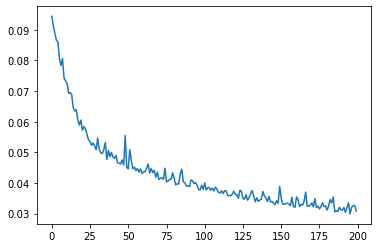

In [7]:
plt.plot(error_plot)
plt.show()

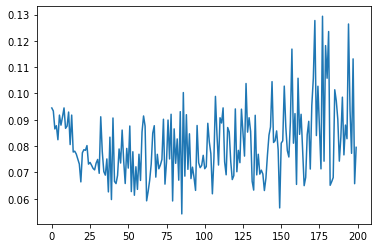

In [8]:
plt.plot(validation_plot)
plt.show()

In [9]:
# Save final network parameters
model.save(f"msd_network_final.torch", epoch)

In [10]:
###############################################################################
#                   Applying the trained network to new data                  #
###############################################################################

# 1) Recreate the model and load the saved parameters.
print(f"Create {task} network model")
if task == "regression":
    model = mp.MSDRegressionModel(
        c_in, c_out, depth, width, dilations=dilations, loss=loss
    )
else:
    model = mp.MSDSegmentationModel(
        c_in, train_ds.num_labels, depth, width, dilations=dilations
    )

# The parameters can be reloaded again:
_ = model.load(f"msd_network_final.torch")

Create segmentation network model


In [11]:
# 2) Load new data.
# The glob pattern for new input data.
new_data_input_glob = "/dls/science/users/lqg38422/DATA/13284/recon/*.tif"

print("Load dataset")
# Since usually no target data is available for new images, just put
# the input images as target as well. They will be ignored in the rest
# of the script.
ds = mp.ImageDataset(new_data_input_glob, new_data_input_glob)

# Do not shuffle when applying to new data:
batch_size = 1
dl = DataLoader(ds, batch_size, shuffle=False)

Load dataset


In [12]:
# 3) apply to new data:
segmentation = []
for i, data in enumerate(dl):
    # data contains a tuple of input and target data. Ignore the
    # target data.
    inp, _ = data
    # Move input to GPU and apply the network:
    output = model.net(inp.cuda())
    # Output has dimensions BxCxHxW (batch size, # channels, height, width).

    prediction = torch.max(output.data, 1).indices

    # To convert to a numpy array, detach the output tensor from the
    # pytorch computation graph, move it to cpu, and convert it to a
    # numpy array.
    prediction_numpy = prediction.detach().cpu().numpy()

    # Optionally, if the prediction has a single output channel, you
    # may want to remove the channel dimension as follows:
    prediction_numpy = prediction_numpy.squeeze()
    
    # Add to tensor
    segmentation.append(prediction_numpy)

segmentation = np.stack(segmentation)

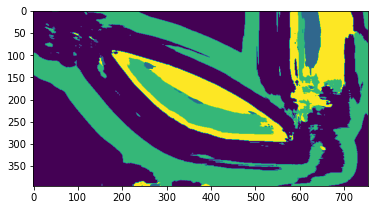

In [18]:
plt.imshow(segmentation[100])

In [19]:
from PIL import Image
im = np.array(Image.open("/dls/science/users/lqg38422/DATA/13284/gt/13284_gt_00100.tif"))

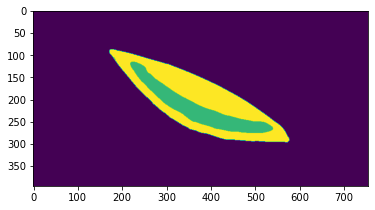

In [20]:
plt.imshow(im)